In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model


from env_test import GridEnvironment
from DQL_agent import DQNAgent

In [2]:
# Load data
N = 10 # 10 EVs

# Get demand data
# TODO get apparent power from real and reactive, use just real for now
with open('Building Load Data/real_power_data.json', 'r') as json_file:
    real_dict = json.load(json_file)
    for key in real_dict.keys(): # get data from first key only (CAPTL_WF)
        demand_data = np.array(real_dict[key])
        break

# Get solar data
with open('PV Generation Data/pv_data.json', 'r') as json_file:
    pv_dict = json.load(json_file)
    for key in pv_dict.keys(): # get data from first key only (CAPTL_WF)
        solar_data = np.array(pv_dict[key])
        break

# Get wind data
with open('Wind Data/wind_data.json', 'r') as json_file:
    wind_dict = json.load(json_file)
    for key in wind_dict.keys(): # get data from first key only (CAPTL_WF)
        wind_data = np.array(wind_dict[key])
        break

In [3]:
# Initialize environment with your chosen day's data

#Quick fix for scaling
demand_data=demand_data/300
wind_data=wind_data*10

day_index=19 #random
timestep_length=.25 #in hours
batch_size = 32 #TWEAk
env = GridEnvironment(N, demand_data, solar_data, wind_data, day_index, timestep_length)

# Initialize DQN agent
agent = DQNAgent(state_size=env.state_size, action_size=env.action_size)

# Run for one episode (one day)
state = env.get_state()  # Reset environment to start state
total_reward = 0

T=96 #(15 minute steps in 24 hrs)

demand_profile = np.zeros(T)
solar_profile = np.zeros(T)
wind_profile = np.zeros(T)
PEV_profile = np.zeros(T)

for timestep in range(1, T+1):  # Assume T timesteps in a day
    action = agent.act(state)  # Decide action based on current state



    reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)

    demand_profile[timestep - 1] = next_demand
    solar_profile[timestep - 1] = next_solar
    wind_profile[timestep - 1] = next_wind
    PEV_profile[timestep - 1] = np.sum(next_P_EV)

    # Construct the new state from the separated components
    next_state = np.concatenate([
        np.array([next_demand, next_solar, next_wind]),  # Assuming these are scalar values
        np.array(next_P_EV)  # Assuming this is already an array or list
    ])
    
    agent.remember(state, action, reward, next_state, done)  # Store experience
    
    if done:
        print(f"Episode finished after {timestep} timesteps with total reward {total_reward}")  # This should be the point where the loop exits if the episode is done

    #Replay not working?\
   # if len(agent.memory) >= batch_size:
       # agent.replay(batch_size) # Train the agent with a minibatch from memory

    state = next_state  # Move to the next state
    total_reward += reward

print("Total reward for the episode (day):", total_reward)


Episode finished after 48 timesteps with total reward -12.425810963333328
Episode finished after 49 timesteps with total reward -12.690189919999995
Episode finished after 50 timesteps with total reward -12.954568876666661
Episode finished after 51 timesteps with total reward -13.218947833333328
Episode finished after 52 timesteps with total reward -13.483326789999994
Episode finished after 53 timesteps with total reward -13.74770574666666
Episode finished after 54 timesteps with total reward -14.012084703333327
Episode finished after 55 timesteps with total reward -14.276463659999994
Episode finished after 56 timesteps with total reward -14.54084261666666
Episode finished after 57 timesteps with total reward -14.805221573333327
Episode finished after 58 timesteps with total reward -15.069600529999994
Episode finished after 59 timesteps with total reward -15.33397948666666
Episode finished after 60 timesteps with total reward -15.598358443333327
Episode finished after 61 timesteps with 

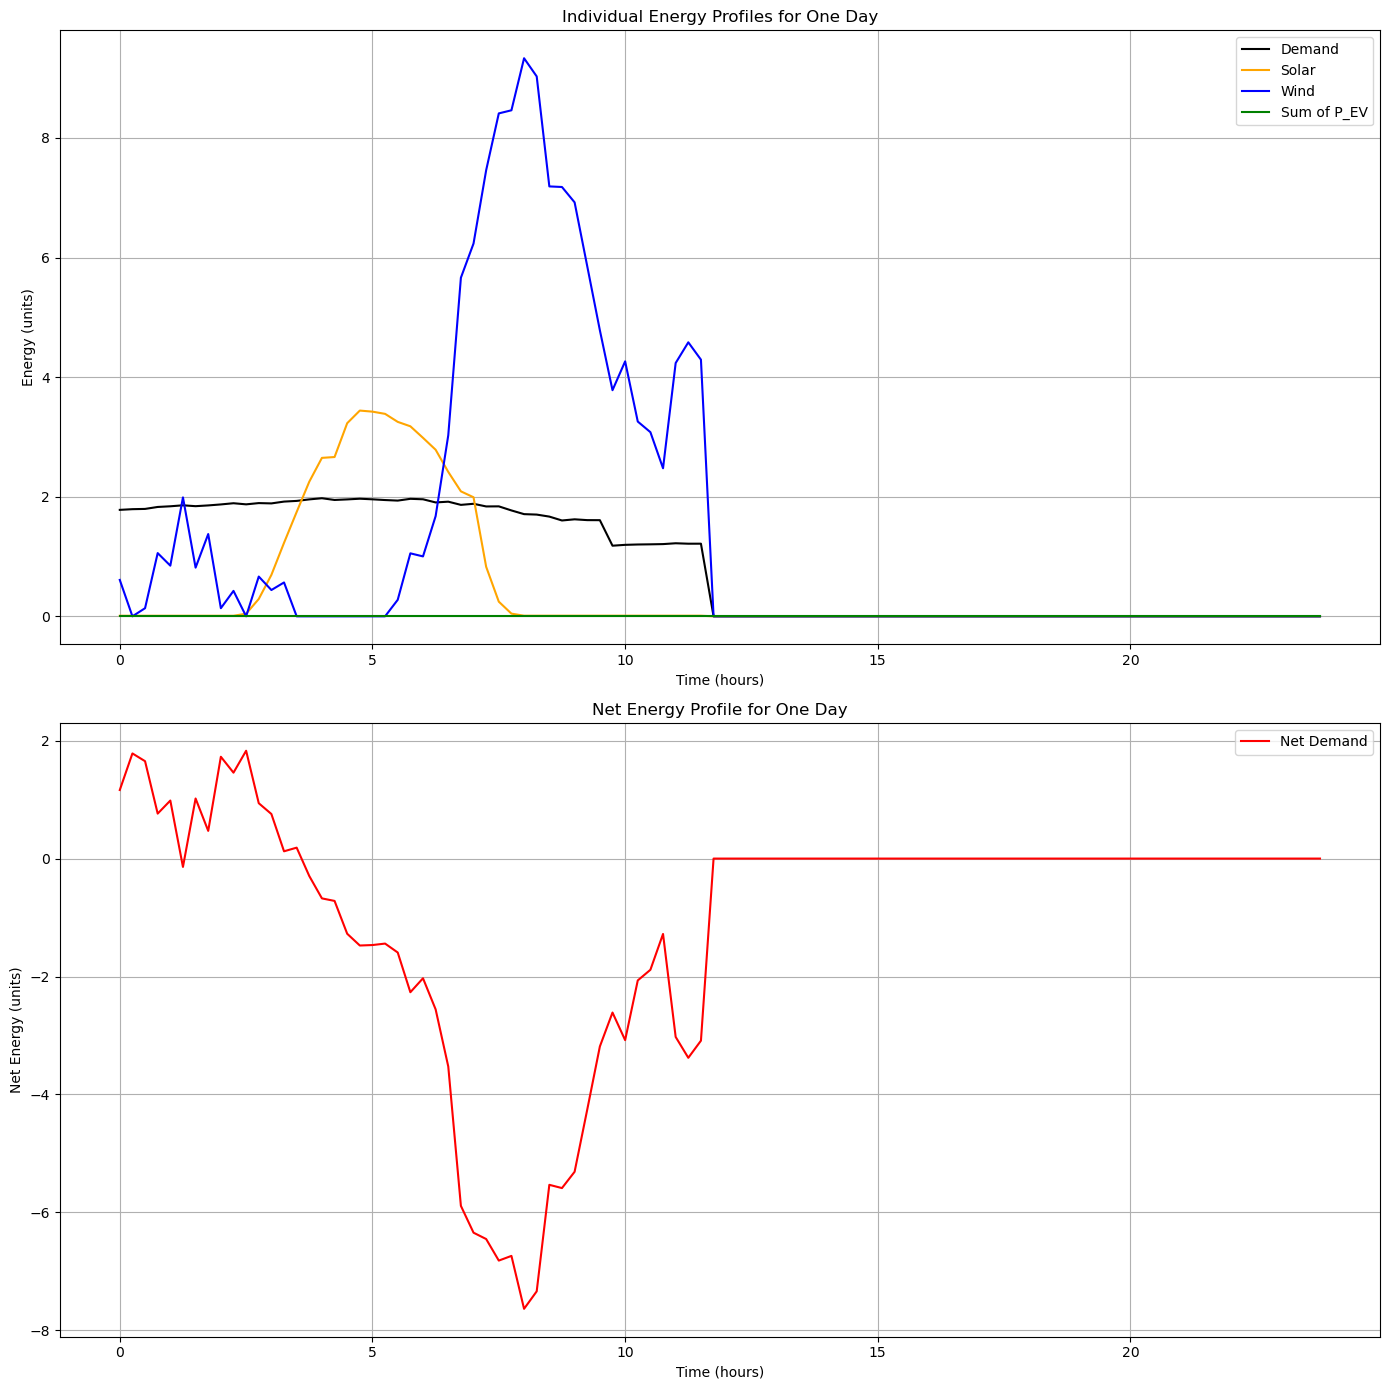

In [4]:
#Plot Episode

time_steps = np.arange(0, T * timestep_length, timestep_length)  # Generate a time axis

plt.figure(figsize=(14, 14))  # Increase the figure size to accommodate two subplots

# First subplot for individual profiles
plt.subplot(2, 1, 1)  # (rows, columns, panel number)
plt.plot(time_steps, demand_profile, label='Demand', color='black')
plt.plot(time_steps, solar_profile, label='Solar', color='orange')
plt.plot(time_steps, wind_profile, label='Wind', color='blue')
plt.plot(time_steps, PEV_profile, label='Sum of P_EV', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (units)')
plt.title('Individual Energy Profiles for One Day')
plt.legend()
plt.grid(True)

# Second subplot for net demand
plt.subplot(2, 1, 2)  # (rows, columns, panel number)
net_demand_profile = demand_profile - solar_profile - wind_profile
plt.plot(time_steps, net_demand_profile, label='Net Demand', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Net Energy (units)')
plt.title('Net Energy Profile for One Day')
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()